In [176]:
import numpy as np

def _line_search(func, grad, hess, x, direction=0, max_iters=100, tol=1e-6, m=20, callback=None):
    f = func(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    fvals = []
    fvals.append(f)
    ngvals = []
    ngvals.append(norm_g)
    # direction = 2  # 0 = Steepest Descent, 1 = Newton, 2 = BFGS
    iter = 1
    c = 0.1
    rho = 0.9
    n = len(x)

    # Initialize B_k as the identity matrix
    if direction == 2:
        B_k = np.eye(n)

    while norm_g > tol and iter < max_iters:
        # Choose search direction
        if direction == 0:  # Steepest descent
            p = -g
        elif direction == 1:  # Newton's method
            H = hess(x)
            spd = np.all(np.linalg.eigvals(H) > 0)
            if spd:
                p = np.linalg.solve(H, -g)
            else:
                p = -g  # Fall back to steepest descent if H is not SPD
        elif direction == 2:  # BFGS quasi-Newton method
            # Reset B_k every m steps
            if iter % m == 0:
                B_k = np.eye(n)
            # Compute search direction using B_k approximation
            p = -np.linalg.solve(B_k, g)
        else:
            print("Direction is out of range")
            break

        # Normalize the search direction if its length is greater than 1
        norm_p = np.linalg.norm(p)
        if norm_p > 1:
            p = p / norm_p

        # Perform backtracking line search along direction p
        a = 1  # Initial step length
        f_temp = func(x + a * p)
        cpg = c * np.dot(p, g)
        while f_temp > f + a * cpg:  # Check Wolfe's condition 1
            a *= rho
            if a < 1e-14:
                print("Line search failed")
                iter = max_iters - 1
                break
            f_temp = func(x + a * p)

        # Update position
        s = a * p  # Step
        x = x + s
        f = func(x)
        g_new = grad(x)
        if direction == 2:
            # BFGS Update
            y = g_new - g  # Change in gradient
            if np.dot(s, y) > 1e-10:  # Safeguard to avoid division by zero or near-zero values
                Bs = B_k @ s
                sy = np.dot(s, y)
                B_k = B_k + np.outer(y, y) / sy - np.outer(Bs, Bs) / np.dot(s, Bs)

        if callback is not None:
            callback(x=x, f=f, g_new=g_new, iter=iter,a=np.linalg.norm(s))

        # Update for the next iteration
        g = g_new
        norm_g = np.linalg.norm(g)
        fvals.append(f)
        ngvals.append(norm_g)
        iter += 1

    return x, fvals, ngvals

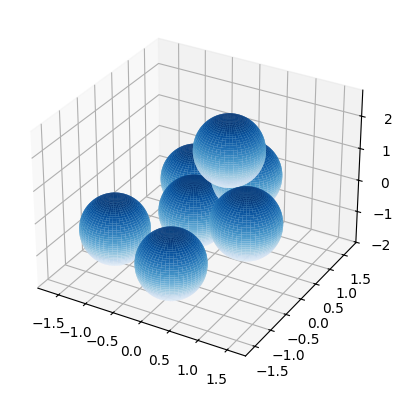

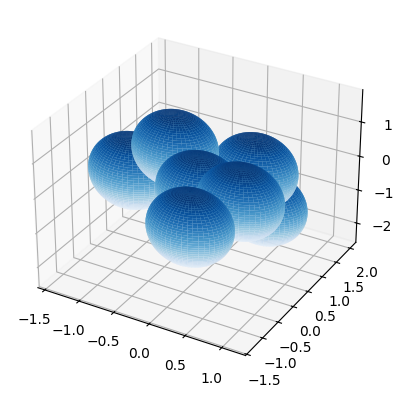

LJpot =  3161.844936568346


In [171]:
from LJhelpers import *
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for backtracking line search
c = 0.1;
rho = 0.9;

model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x0 = remove_rotations_translations(xyz)
drawconf(LJvector2array(x0),0.5*rstar)
print("LJpot = ",LJpot(x0))
# print(LJhess(x))



In [172]:
import matplotlib.pyplot as plt

fvalss = {}
ngvalss = {}

for direction, method in [(0, "SD"), (1, "Newton"), (2, "BFGS")]:
    fvalss[method] = {}
    ngvalss[method] = {}
    xyzs = [initial_configuration(model,Na,rstar) for model in range(1,5)] 
    for _ in range(10):
        xyzs.append(initial_configuration(5,Na,rstar))
    confs = list(range(1,5))+[f'rand{i}' for i in range(10)]

    x0s = [remove_rotations_translations(xyz) for xyz in xyzs]
    for conf,x0 in zip(confs,x0s):
        xopt,fvals,ngvals = _line_search(LJpot, LJgrad, LJhess, x0,direction=direction,max_iters=1000)
        print("Optimization result:", xopt)
        fvalss[method][conf] = fvals
        ngvalss[method][conf] = ngvals


Optimization result: [ 1.12408795  1.47145025  1.06907114  0.56204403  1.72979346  0.
 -0.34736223  1.06907118  0.          0.56204399  0.77358715  0.57387017
  0.56204399  0.77358715 -0.57387017]
Optimization result: [ 1.11959052e+00  1.11850573e+00  1.11536611e+00  1.08481735e-03
  1.11536611e+00  2.71438141e-08  5.59795278e-01  5.61370987e-01
  7.90553474e-01  5.59795256e-01  5.55082971e-01 -7.89021485e-01
  5.59795261e-01 -5.56644382e-01  7.91666524e-01]
Optimization result: [ 1.11879351  0.55939675  0.96890359  0.55939675 -0.74773547  0.61550281
  1.48665302  0.85831953  0.61550284 -0.36785949  0.8583195   0.61550288
  0.55939677  0.32296784  0.92200413]
Optimization result: [ 1.12732544  0.55331257  0.97024324  0.56473135 -0.75264353  0.60114798
  1.48863288  0.86743381 -0.6011479   0.56882923  0.32552948  0.91104996
  0.56277974  0.31492157 -0.91104996]
Optimization result: [ 1.12575514  0.56981765  0.97089259  0.56981767  0.32628012  0.91442534
  0.55820153 -0.74888116  0.60657

SD
Newton
BFGS


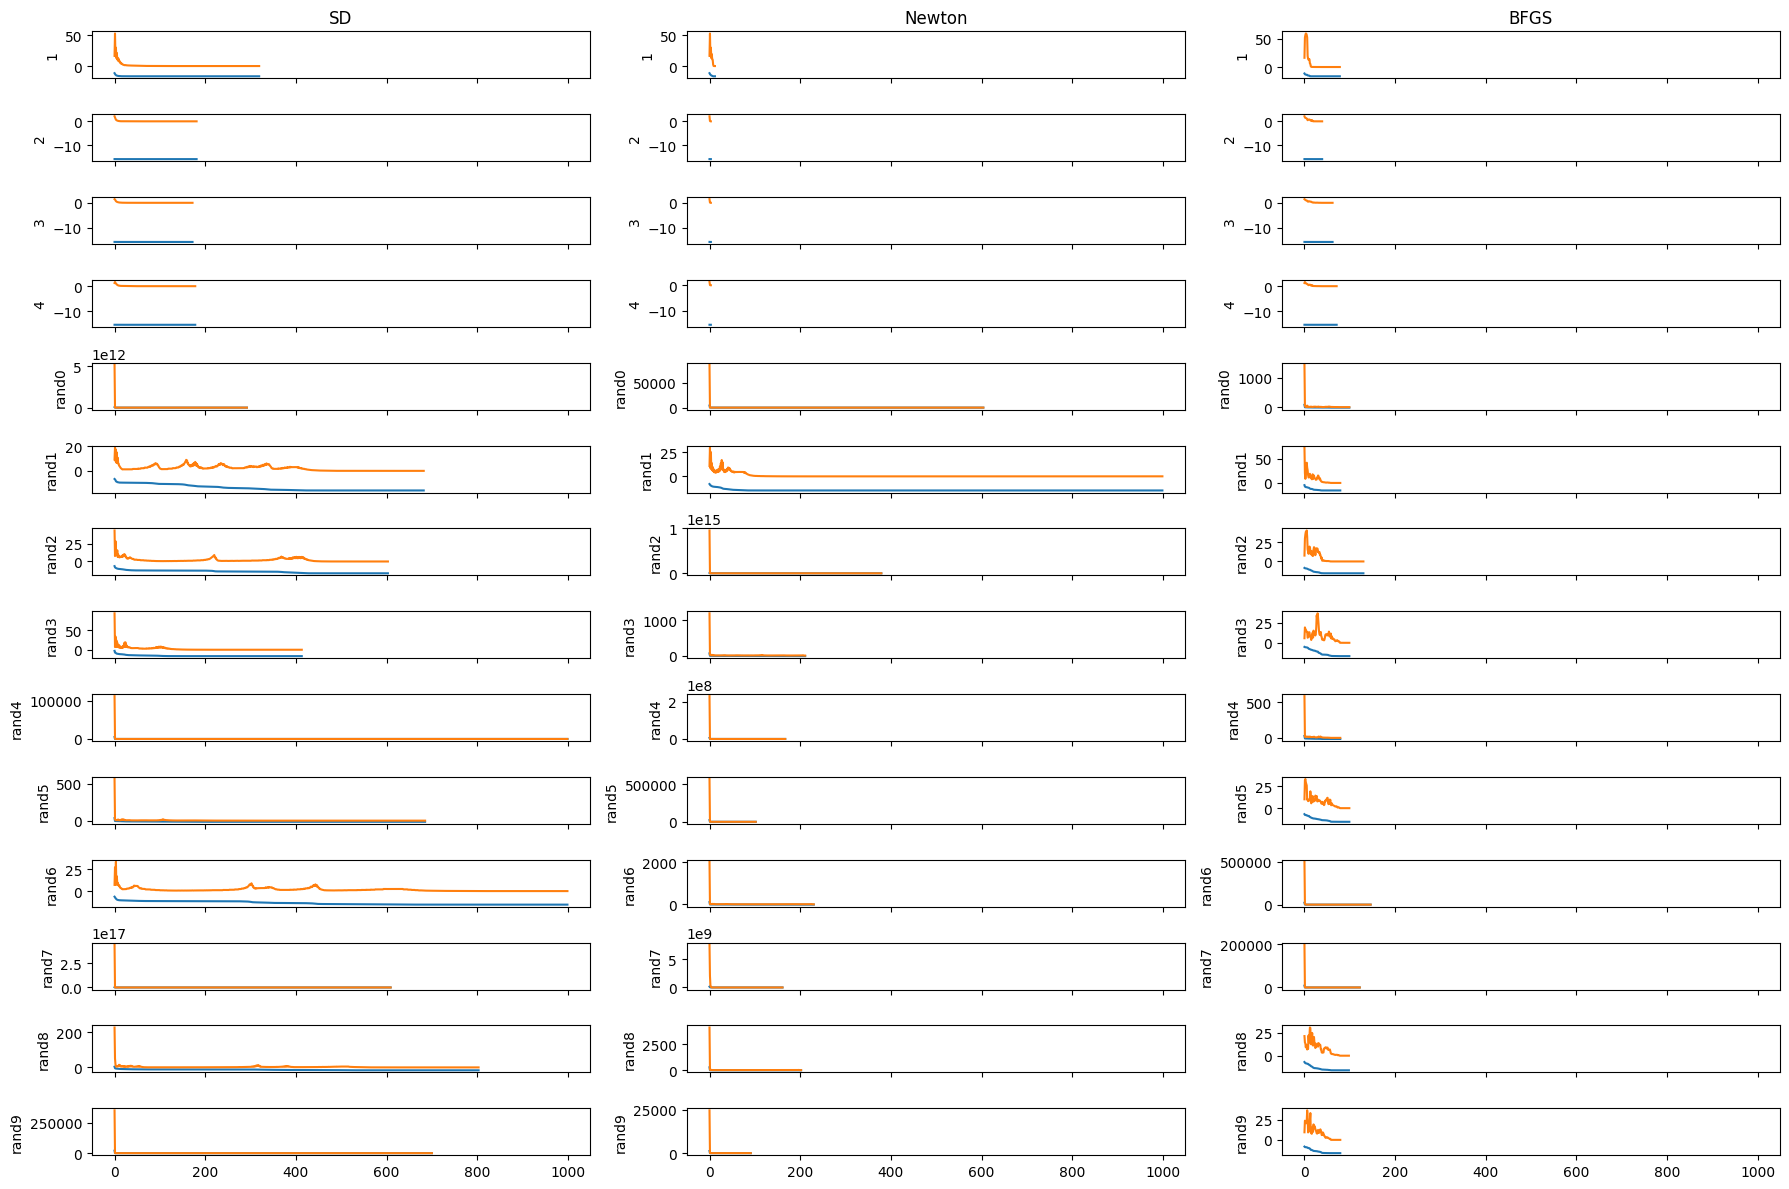

In [173]:
fig,ax = plt.subplots(len(confs),3,figsize = (18,12), sharex=True)
for i,method in enumerate(list(fvalss.keys())):
    print(method)
    ax[0,i].set_title(f'{method}')
    for j,conf in enumerate(list(fvalss[method].keys())):
        
        # print(conf)
        ax[j,i].set_ylabel(f'{conf}')
        ax[j,i].plot(fvalss[method][conf])
        ax[j,i].plot(ngvalss[method][conf])

plt.tight_layout()
plt.show()
#         ax[i].plot(fvals)
# ax[0].plot(fvals)
# ax[1].plot(ngvals)


In [177]:
import numpy as np

# Define the quadratic function, gradient, and Hessian
a = 1
b = 100

# Define the Rosenbrock function, its gradient, and Hessian
def func(x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

def grad(x):
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)
    df_dy = 2 * b * (x[1] - x[0] ** 2)
    return np.array([df_dx, df_dy])

def hess(x):
    d2f_dx2 = 2 - 4 * b * (x[1] - x[0] ** 2) + 8 * b * x[0] ** 2
    d2f_dxdy = -4 * b * x[0]
    d2f_dy2 = 2 * b
    return np.array([[d2f_dx2, d2f_dxdy],
                     [d2f_dxdy, d2f_dy2]])


# x0 = np.array([1.2, 1.2])
# x0 = np.array([-1.2, 1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
xk = {}
ak = {}
for i,x0 in enumerate(x0s):
    xk[i] = {}
    ak[i] = {}
    for direction in [0,1,2]:
        xk[i][direction] = []
        ak[i][direction] = []
        # xopt,fvals,ngvals = _line_search(func, grad, hess, x0,direction=2)
        
        def callback(**kwargs):
            x = kwargs['x']
            a = kwargs['a']
            xk[i][direction].append(x)
            ak[i][direction].append(a)
        xopt,fvals,ngvals = _line_search(func, grad, hess, x0,direction=direction,callback=callback,max_iters=10000)
        
        # Output final results
        print("Optimization result:", xopt)
    #     import matplotlib.pyplot as plt
    #     ax[i].set_title(f'x0 = {x0}')
    #     l, = ax[i].plot(np.linalg.norm(xk[i][direction]-xopt_true, axis=1))
    #     l.set_label(f'direction = {direction}')
    # ax[i].set_yscale('log')
# fig.legend()
# plt.show()

Optimization result: [1.00005395 1.00010842]
Optimization result: [1. 1.]
Optimization result: [1. 1.]
Optimization result: [0.99993361 0.99986732]
Optimization result: [0.99999951 0.99999901]
Optimization result: [1. 1.]


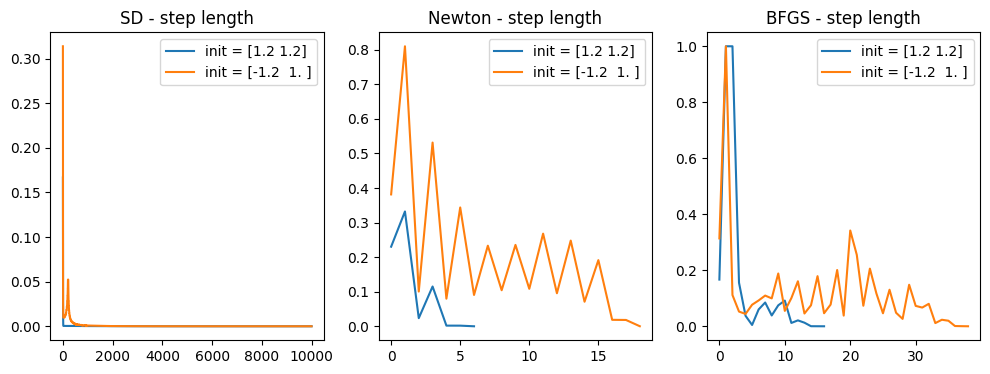

In [178]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
method_dict = {0:'SD',1:'Newton',2:'BFGS'}
for direction in [0,1,2]:
    for i,x0 in enumerate(x0s):
        ax[direction].set_title(f"{method_dict[direction]} - step length")
        l, = ax[direction].plot(ak[i][direction])
        l.set_label(f'init = {x0}')
        ax[direction].legend()

# fig.legend()
plt.show()

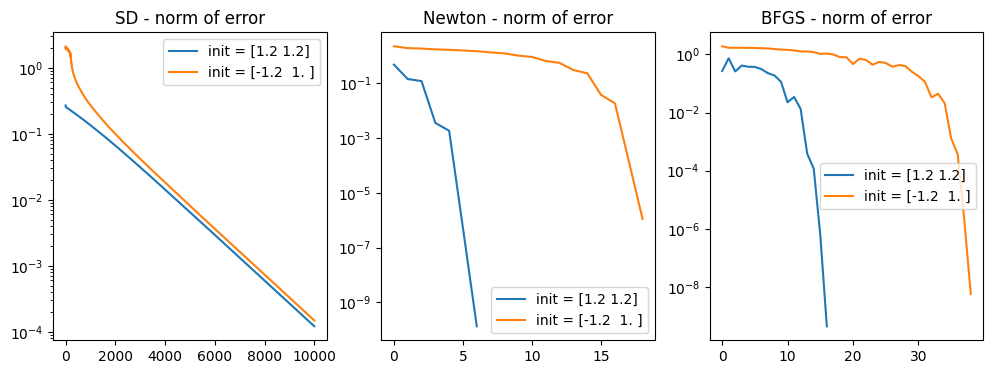

In [187]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
method_dict = {0:'SD',1:'Newton',2:'BFGS'}
for direction in [0,1,2]:
    for i,x0 in enumerate(x0s):
        ax[direction].set_title(f"{method_dict[direction]} - norm of error")
        l, = ax[direction].plot(np.linalg.norm(xk[i][direction]-xopt_true, axis=1))
        l.set_label(f'init = {x0}')
        ax[direction].set_yscale('log')
        ax[direction].legend()

# fig.legend()
plt.show()


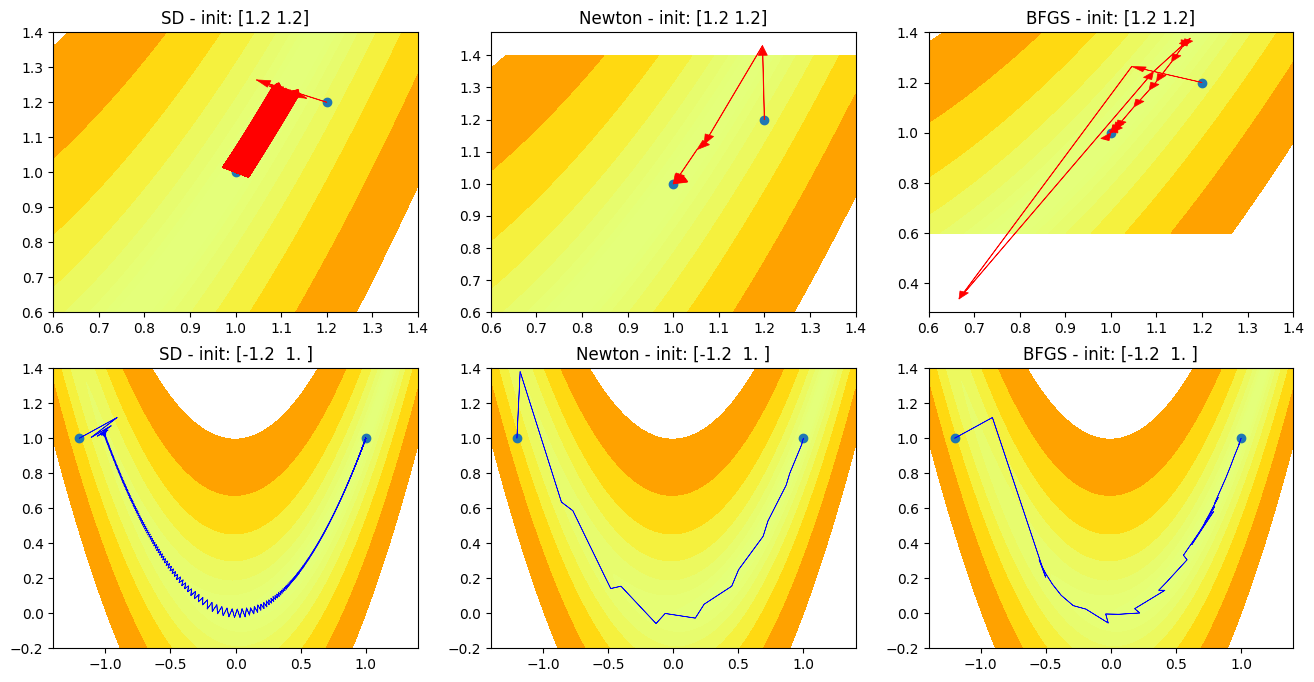

In [185]:


fig, ax = plt.subplots(2,3,figsize=(16,8))
# plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap="viridis")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Optimization Paths on Rosenbrock Function")

xopt_true = np.array([1.0,1.0])
x0s = [np.array([1.2, 1.2]),np.array([-1.2, 1.0])]
colors = ["red", "blue", "green"]
method_dict = {0:'SD',1:'Newton',2:'BFGS'}
for direction in [0,1,2]:
    for i,x0 in enumerate(x0s):
        ax[i][direction].set_title(f"{method_dict[direction]} - init: {x0}")
        if i == 0:
            x_vals = np.linspace(.6, 1.4, 400)
            y_vals = np.linspace(.6, 1.4, 400)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = func([X,Y])
        else: 
            x_vals = np.linspace(-1.4, 1.4, 400)
            y_vals = np.linspace(-.2, 1.4, 400)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = func([X,Y])
        ax[i][direction].contourf(X, Y, Z, levels=np.logspace(-3, 2, 16), cmap="Wistia")
        points = np.array(xk[i][direction])
        points = np.concatenate([[x0],points],axis=0)
        ax[i][direction].scatter([x0[0],xopt_true[0]],[x0[1],xopt_true[1]])
        for j in range(len(points) - 1):
            ax[i][direction].arrow(points[j, 0], points[j, 1],
                    points[j+1, 0] - points[j, 0], points[j+1, 1] - points[j, 1],
                    color=colors[i], shape='full', lw=.5, length_includes_head=True, head_width=np.mean(x_vals)/50)
# x0 = np.array([-1.2, 1.0])

# # Run line search with different methods and plot their paths
# methods = ["Steepest Descent", "Newton", "BFGS"]
# colors = ["red", "blue", "green"]
# for i, method in enumerate(methods):
#     points = np.array(xk[1][i])
#     plt.plot(points[:, 0], points[:, 1], 'o-', color=colors[i], label=method)

# plt.legend()
# plt.show()

In [5]:
import scipy
import scipy.optimize
scipy.optimize.minimize(func,x0,method='CG')

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 2.7210829810088844e-09
       x: [ 1.000e+00  9.999e-01]
     nit: 29
     jac: [ 1.500e-03 -7.802e-04]
    nfev: 309
    njev: 99